In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from boa.models.gpar_v2 import GPARModel
from boa.models.fully_factorized_gp_v2 import FullyFactorizedGPModel

from itertools import permutations

In [8]:
def toy_y(xs):
    
    xs = xs.reshape((-1, 1))
    
    def y1(x, eps_loc=0., eps_scale=0.05):
        
        eps = np.random.normal(loc=eps_loc, scale=eps_scale, size=x.shape)
        
        return -np.sin(10 * np.pi * (x + 1)) / (2 * x + 1) - x**4 + eps
    
    
    def y2(x, eps_loc=0., eps_scale=0.05):
        
        eps = np.random.normal(loc=eps_loc, scale=eps_scale, size=x.shape)
        
        return np.cos(y1(x))**2 + np.sin(3 * x) + eps
    
    
    def y3(x, eps_loc=0., eps_scale=0.05):
        
        eps = np.random.normal(loc=eps_loc, scale=eps_scale, size=x.shape)
        
        return y2(x) * y1(x)**2 + 3 * x + eps
    
    
    return np.concatenate([y1(xs), y2(xs), y3(xs)], axis=1)

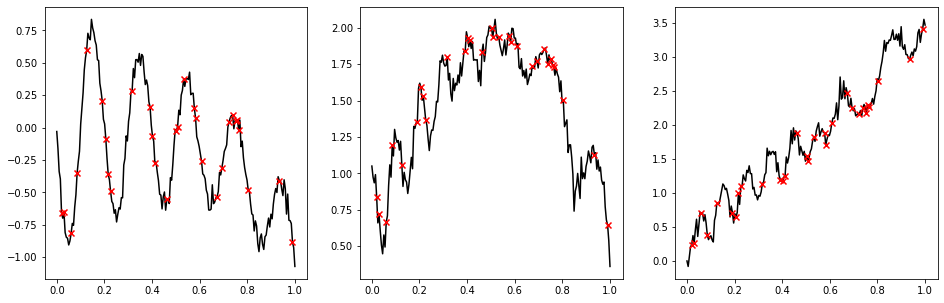

In [18]:
np.random.seed(40)

num_points = 200

xs = np.linspace(0, 1, num_points)

ys = toy_y(xs)

plt.figure(figsize=(16, 5))

train_indices = np.random.choice(num_points, 30, replace=False) 

for i in range(3):
    plt.subplot(int(f"13{i + 1}"))
    plt.plot(xs, ys[:, i], color='k', zorder=-1)
    plt.scatter(xs[train_indices], ys[train_indices, i], color='r', marker='x')

In [ ]:
perms = list(permutations(range(3)))

gps = {}

for perm in perms:
    
    gp_input = xs[train_indices].reshape((-1, 1))
    gp_output = ys[train_indices]
    gp_output = gp_output[:, perm]
    
    gpar = GPARModel(kernel="rbf", num_optimizer_restarts=5) | (gp_input, gp_output) 
    ff_gp = FullyFactorizedGPModel(kernel="rbf", num_optimizer_restarts=5) | (gp_input, gp_output) 
    
    gpar.train()
    ff_gp.train()
    
    gps[str(perm)] = {}
    gps[str(perm)]["gpar"] = gpar
    gps[str(perm)]["ff_gp"] = ff_gp

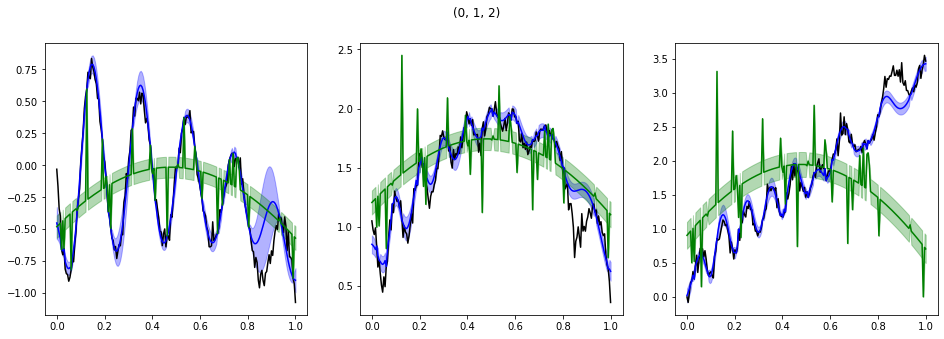

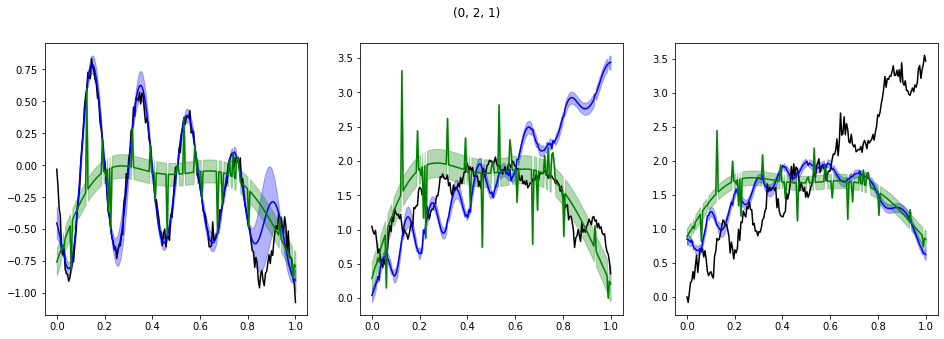

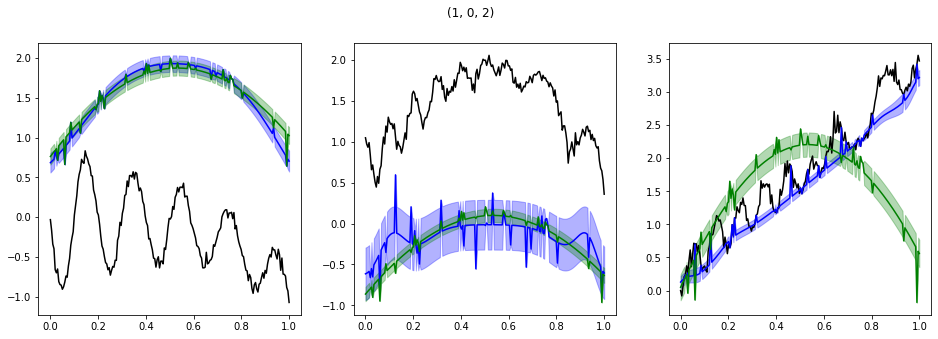

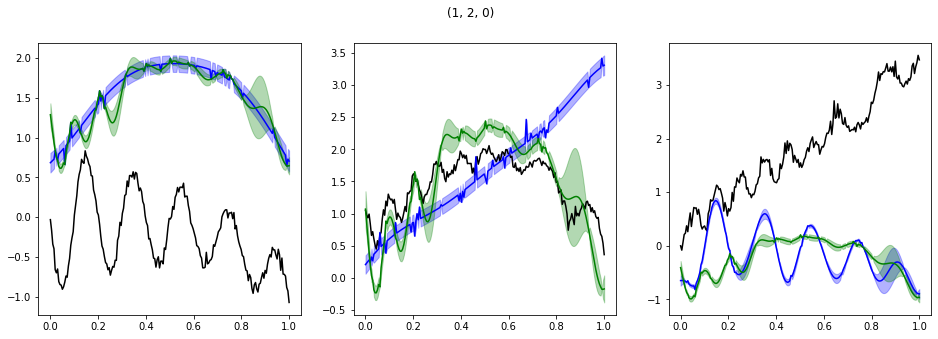

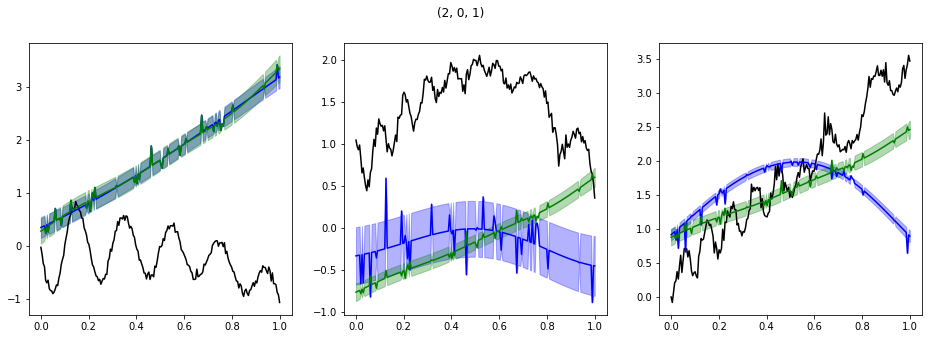

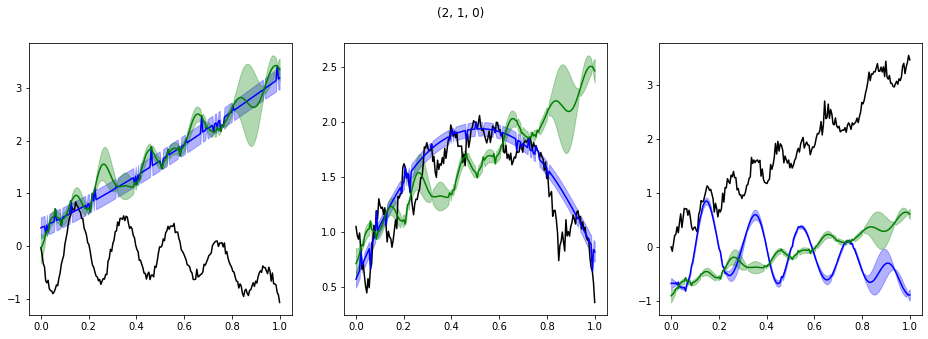

In [54]:
for k, v in gps.items():
    
    gpar = v["gpar"]
    ff_gp = v["ff_gp"]

    means, var = gpar.predict_batch(xs.reshape((-1, 1 )))
    means_, var_ = ff_gp.predict_batch(xs.reshape((-1, 1 )))

    plt.figure(figsize=(16, 5))
    plt.suptitle(k)

    for i in range(3):
        plt.subplot(int(f"13{i + 1}"))

        plt.plot(xs, ys[:, i], color='k')

        plt.plot(xs, means[:, i], color='blue')
        plt.fill_between(xs, 
                         (means[:, i].numpy() + np.sqrt(var[:, i].numpy())).T, 
                         (means[:, i].numpy() - np.sqrt(var[:, i].numpy())).T,
                         color='blue',
                         alpha=0.3,
                         zorder=-1)

        plt.plot(xs, means_[:, i], color='green')
        plt.fill_between(xs, 
                         (means_[:, i].numpy() + np.sqrt(var_[:, i].numpy())).T, 
                         (means_[:, i].numpy() - np.sqrt(var_[:, i].numpy())).T,
                         color='green',
                         alpha=0.3,
                         zorder=-1)
        
    plt.show()